<a href="https://colab.research.google.com/github/AdarshRegulapati/URL_Phishing_Detection/blob/main/BERT_Test_3(good)_Sun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# same as BERT_Test_1_sun.ipynb but added code to remove http:// and https://
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar

In [ ]:
# Base 201.ipynb contains:
# LSTM generator and BERT(Pre-trained) discriminator
# Total Layers:
# The Generator has 2 main layers:
# A single-layer LSTM for sequential processing.
# A fully connected (linear) layer for mapping hidden states to the vocabulary.

# Additions in this file from 201.ipynb

#reading input from text file


# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# ===================================
#       Data Preparation
# ===================================
#words = ['aaaa111', 'aaaa111', 'aaaa111', 'aaaa111', 'aaaa111', 'aaaa111', 'aaaa111', 'aaaa111', 'aaaa111', 'aaaa111']
# end_text = ['https://aws.amazon.com/', 'https://cloud.amazon.com/', 'https://online.amazon.com/', 'https://apple.amazon.com/',
#          'https://melon.amazon.com/', 'https://penn.amazon.com/', 'https://psu.amazon.com/', 'https://state.amazon.com/',
#          'https://new.amazon.com/', 'https://yo.amazon.com/']

#Load dataset of malicious URLs from a file
with open('newHostnames.txt', 'r') as f:
    words = f.read().splitlines()

# print('------------------------------------------------------------------------')
# print(words)
# print('-------------------------------------------------------------------------------')

# Build character vocabulary
chars = set(''.join(words))
char2idx = {ch: idx+1 for idx, ch in enumerate(sorted(chars))}
char2idx['<PAD>'] = 0  # Padding character
idx2char = {idx: ch for ch, idx in char2idx.items()}

vocab_size = len(char2idx)
print('Vocabulary size:', vocab_size)

# Encode words as sequences of character indices
max_length = max(len(w) for w in words)
print('Maximum word length:', max_length)

def encode_word(word):
    return [char2idx[ch] for ch in word]

def pad_sequence(seq, max_length):
    return seq + [char2idx['<PAD>']] * (max_length - len(seq))

encoded_words = [pad_sequence(encode_word(w), max_length) for w in words]

# Create Dataset and DataLoader
class WordDataset(Dataset):
    def __init__(self, encoded_words):
        self.encoded_words = encoded_words

    def __len__(self):
        return len(self.encoded_words)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded_words[idx], dtype=torch.long)

batch_size = 32
dataset = WordDataset(encoded_words)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ===================================
#       Define the Generator
# ===================================

class Generator(nn.Module):
    def __init__(self, noise_dim, hidden_dim, vocab_size, max_length, num_layers=2):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(input_size=noise_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, vocab_size)
        )

    def forward(self, noise):
        # noise: (batch_size, max_length, noise_dim)
        h0 = torch.zeros(self.num_layers, noise.size(0), self.hidden_dim).to(noise.device)
        c0 = torch.zeros(self.num_layers, noise.size(0), self.hidden_dim).to(noise.device)

        # Pass through LSTM layers
        out, _ = self.lstm(noise, (h0, c0))  # Output shape: (batch_size, max_length, hidden_dim)
        out = self.dropout(out)

        # Pass through fully connected layers
        out = self.fc(out)  # Output shape: (batch_size, max_length, vocab_size)
        return out

# ===================================
#     Define the Discriminator
# ===================================

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Shape: (batch_size, 1)
        return logits

# Instantiate models
noise_dim = 100
hidden_dim = 128

generator = Generator(noise_dim, hidden_dim, vocab_size, max_length, num_layers=2).to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCEWithLogitsLoss()

lr = 2e-4
beta1 = 0.5

# Freeze BERT's base layers to prevent overfitting
for param in discriminator.bert.base_model.parameters():
    param.requires_grad = False

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(filter(lambda p: p.requires_grad, discriminator.parameters()), lr=lr, betas=(beta1, 0.999))

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Label smoothing
real_label = 0.9
fake_label = 0.1

# ===================================
#     Initialize Lists for Plots
# ===================================

g_losses = []
d_losses = []
accuracies = []

# ===================================
#            Training Loop
# ===================================
# Initialize an empty set to collect unique words
all_generated_words = set()

# ===================================
#            Training Loop
# ===================================

epochs = 10

for epoch in range(epochs):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    correct = 0
    total = 0

    for i, real_words in enumerate(dataloader):
        real_words = real_words.to(device)  # Shape: (batch_size, max_length)
        batch_size_current = real_words.size(0)

        # ===================== Train Discriminator =====================
        discriminator.zero_grad()

        # Prepare real words
        real_words_str = []
        for word_indices in real_words:
            chars = [idx2char[idx.item()] for idx in word_indices if idx.item() != char2idx['<PAD>']]
            real_word = ''.join(chars)
            real_words_str.append(real_word)

        # Tokenize real words
        real_inputs = tokenizer(real_words_str, return_tensors='pt', padding=True, truncation=True, max_length=20).to(device)

        # Real labels with label smoothing
        real_labels = torch.full((batch_size_current, 1), real_label, device=device)

        # Discriminator output for real words
        real_outputs = discriminator(input_ids=real_inputs['input_ids'], attention_mask=real_inputs['attention_mask'])
        d_loss_real = criterion(real_outputs, real_labels)

        # Compute accuracy on real words
        preds_real = torch.sigmoid(real_outputs) >= 0.5
        correct += preds_real.eq(torch.ones_like(preds_real)).sum().item()
        total += batch_size_current

        # Prepare fake words
        noise = torch.randn(batch_size_current, max_length, noise_dim).to(device)
        fake_logits = generator(noise)
        fake_probs = torch.softmax(fake_logits, dim=2)
        fake_probs_reshaped = fake_probs.view(-1, vocab_size)
        fake_indices = torch.multinomial(fake_probs_reshaped, num_samples=1).squeeze(1)
        fake_indices = fake_indices.view(batch_size_current, max_length)

        # Convert fake indices to words
        fake_words_str = []
        for word_indices in fake_indices:
            chars = [idx2char[idx.item()] for idx in word_indices if idx.item() != char2idx['<PAD>']]
            fake_word = ''.join(chars)
            fake_words_str.append(fake_word)

        # Add generated words to the set
        all_generated_words.update(fake_words_str)

        # Tokenize fake words
        fake_inputs = tokenizer(fake_words_str, return_tensors='pt', padding=True, truncation=True, max_length=20).to(device)

        # Fake labels with label smoothing
        fake_labels_tensor = torch.full((batch_size_current, 1), fake_label, device=device)

        # Discriminator output for fake words
        fake_outputs = discriminator(input_ids=fake_inputs['input_ids'], attention_mask=fake_inputs['attention_mask'])
        d_loss_fake = criterion(fake_outputs, fake_labels_tensor)

        # Compute accuracy on fake words
        preds_fake = torch.sigmoid(fake_outputs) < 0.5
        correct += preds_fake.eq(torch.ones_like(preds_fake)).sum().item()
        total += batch_size_current

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Accumulate discriminator loss
        epoch_d_loss += d_loss.item()

        # ===================== Train Generator =====================
        generator.zero_grad()

        # Generate fake words
        noise = torch.randn(batch_size_current, max_length, noise_dim).to(device)
        fake_logits = generator(noise)
        fake_probs = torch.softmax(fake_logits, dim=2)
        fake_probs_reshaped = fake_probs.view(-1, vocab_size)
        fake_indices = torch.multinomial(fake_probs_reshaped, num_samples=1).squeeze(1)
        fake_indices = fake_indices.view(batch_size_current, max_length)

        # Convert fake indices to words
        fake_words_str = []
        for word_indices in fake_indices:
            chars = [idx2char[idx.item()] for idx in word_indices if idx.item() != char2idx['<PAD>']]
            fake_word = ''.join(chars)
            fake_words_str.append(fake_word)

        # Add generated words to the set
        all_generated_words.update(fake_words_str)

        # Tokenize fake words
        fake_inputs = tokenizer(fake_words_str, return_tensors='pt', padding=True, truncation=True, max_length=20).to(device)

        # Generator wants the discriminator to think these are real
        valid_labels = torch.full((batch_size_current, 1), real_label, device=device)  # Use real_label for generator

        # Discriminator output for fake words
        outputs = discriminator(input_ids=fake_inputs['input_ids'], attention_mask=fake_inputs['attention_mask'])
        g_loss = criterion(outputs, valid_labels)
        g_loss.backward()
        optimizer_G.step()

        # Accumulate generator loss
        epoch_g_loss += g_loss.item()

        # Print losses
        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}')

    # Compute average losses and accuracy
    avg_d_loss = epoch_d_loss / len(dataloader)
    avg_g_loss = epoch_g_loss / len(dataloader)
    accuracy = 100 * correct / total

    # Append losses and accuracy to lists
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)
    accuracies.append(accuracy)

    # Print epoch summary
    print(f'Epoch {epoch+1} completed.')
    print(f'Average D_loss: {avg_d_loss:.4f}, Average G_loss: {avg_g_loss:.4f}, Accuracy: {accuracy:.2f}%')

print('Training completed.')

# After training, print all unique generated words
print("All uniqxxue generated words after training:")
for word in all_generated_words:
    print(word)


Using device: cpu
Vocabulary size: 32
Maximum word length: 17


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Step [1/4], D_loss: 1.4557, G_loss: 0.7968
Epoch 1 completed.
Average D_loss: 1.4345, Average G_loss: 0.7857, Accuracy: 50.00%
Epoch [2/10], Step [1/4], D_loss: 1.3961, G_loss: 0.7660
Epoch 2 completed.
Average D_loss: 1.3846, Average G_loss: 0.7647, Accuracy: 50.00%
Epoch [3/10], Step [1/4], D_loss: 1.3594, G_loss: 0.7715
Epoch 3 completed.
Average D_loss: 1.3490, Average G_loss: 0.7700, Accuracy: 51.50%
Epoch [4/10], Step [1/4], D_loss: 1.3309, G_loss: 0.7783
Epoch 4 completed.
Average D_loss: 1.3202, Average G_loss: 0.7727, Accuracy: 77.00%
Epoch [5/10], Step [1/4], D_loss: 1.2926, G_loss: 0.7757
Epoch 5 completed.
Average D_loss: 1.2877, Average G_loss: 0.7904, Accuracy: 85.00%
Epoch [6/10], Step [1/4], D_loss: 1.2643, G_loss: 0.7900
Epoch 6 completed.
Average D_loss: 1.2594, Average G_loss: 0.8098, Accuracy: 85.50%
Epoch [7/10], Step [1/4], D_loss: 1.2395, G_loss: 0.8561
Epoch 7 completed.
Average D_loss: 1.2439, Average G_loss: 0.8503, Accuracy: 82.00%
Epoch [8/10],

In [ ]:
print(f'Number of unique generated words: {len(all_generated_words)}')

Number of unique generated words: 2000


In [ ]:
import random

# Define TLDs
tlds = [
    '.coun', '.kim', '.science', '.gq', '.work', '.ninja', '.xyz', '.date',
    '.faith', '.zip', '.racing', '.cricket', '.win', '.space', '.acc', '.top',
    '.stream', '.christmas', '.gdn', '.mom', '.pro', '.men'
]

# Function to generate complete URL
def generate_url(word):
    # Prepend http:// or https:// randomly
    scheme = random.choice(['http://', 'https://', 'ftp://', 'file://'])

    # Choose a random TLD from the list
    tld = random.choice(tlds)

    # Create the complete URL
    return f"{scheme}{word}{tld}"

# Set to store all unique generated URLs
generated_urls = set()

# After generating words, process them
print("Generated URLs:")
for word in all_generated_words:  # Ensure 'all_generated_words' is defined and populated with words
    url = generate_url(word)
    generated_urls.add(url)  # Add the generated URL to the set
    print(url)

# The set 'generated_urls' now contains all unique URLs



Generated URLs:
http://riisbapjw1wynnqn.kim
file://qz2bs2m3w1z3bgrtm.date
http://1htmcyqvp6xhztvip.faith
ftp://tjitppyljyh6yu.cricket
https://z1kdk0o1zkfvblj.acc
ftp://lfr1quxc1vmdk3xkt.faith
ftp://b210wucerz3oojza.cricket
file://0rfsyyvmwkb2alb6a.faith
ftp://wwpeq6pg2rbzlotki.kim
file://wjgzravspn00rcz2s.work
ftp://lhv3uj61612vlydpz.kim
https://ssmqxvdriogkbb3fd.win
file://0qkslrhkrtmb6dimo.cricket
ftp://6v6tgy6tilga1wm0z.kim
ftp://y33hy1obf66friu.xyz
https://fomanyf21boxeue.top
ftp://wvjfql6lhraix3tmv.mom
https://phgebkptz3ckme26e.mom
http://dzqdqvylv0mk3tov0.christmas
file://ubx0b2pxoupupbhaz.work
file://fq611fqpeznbh3pd.pro
http://npjsieo20t23csut1.faith
http://bqjabwqpnkyix1n3g.top
file://1aqumnk3rffx0eanm.zip
https://dvqgkzpqa6l1tdna3.top
https://cjph1dmmhh1chivq.pro
http://sj6iauiglh6afe2du.xyz
file://orzspl3gqhd2iqgx.work
ftp://wpajcuuuy66e6oh.coun
http://ramjr2lop3dcbmh.science
https://1dextj6wov1vs6qr.gdn
ftp://owu2r1n2qtkvrbdnd.pro
https://w1hadnxhlinupj2a.mom
http://xd0gmfu

Dataset loaded.
Labels encoded.
Tokenizer loaded.
Dataset class defined.
Dataset split into training and validation sets.
Dataset instances created.
DataLoader instances created.
Model initialized.
Using device: cpu

Epoch 1/10


Training Epoch 1: 100%|████████████████████| 113/113 [05:20<00:00,  2.84s/batch]


Train loss: 0.3654, Train accuracy: 0.8269


Validation Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.43batch/s]


Validation loss: 0.2745, Validation accuracy: 0.8950

Epoch 2/10


Training Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [04:42<00:00,  2.50s/batch]


Train loss: 0.2513, Train accuracy: 0.9028


Validation Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.40batch/s]


Validation loss: 0.3789, Validation accuracy: 0.8250

Epoch 3/10


Training Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [04:40<00:00,  2.48s/batch]


Train loss: 0.1966, Train accuracy: 0.9272


Validation Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.54batch/s]


Validation loss: 0.1923, Validation accuracy: 0.9275

Epoch 4/10


Training Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [04:50<00:00,  2.57s/batch]


Train loss: 0.1592, Train accuracy: 0.9458


Validation Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20batch/s]


Validation loss: 0.1751, Validation accuracy: 0.9225

Epoch 5/10


Training Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [07:50<00:00,  4.17s/batch]


Train loss: 0.1351, Train accuracy: 0.9547


Validation Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.46batch/s]


Validation loss: 0.1631, Validation accuracy: 0.9325

Epoch 6/10


Training Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [04:30<00:00,  2.39s/batch]


Train loss: 0.1221, Train accuracy: 0.9586


Validation Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.34batch/s]


Validation loss: 0.1996, Validation accuracy: 0.9250

Epoch 7/10


Training Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [04:53<00:00,  2.60s/batch]


Train loss: 0.0726, Train accuracy: 0.9742


Validation Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.53batch/s]


Validation loss: 0.1849, Validation accuracy: 0.9400

Epoch 8/10


Training Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [04:19<00:00,  2.30s/batch]


Train loss: 0.0608, Train accuracy: 0.9783


Validation Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.53batch/s]


Validation loss: 0.2694, Validation accuracy: 0.9150

Epoch 9/10


Training Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [04:33<00:00,  2.42s/batch]


Train loss: 0.0543, Train accuracy: 0.9797


Validation Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.49batch/s]


Validation loss: 0.2080, Validation accuracy: 0.9525

Epoch 10/10


Training Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [04:33<00:00,  2.42s/batch]


Train loss: 0.0318, Train accuracy: 0.9883


Validation Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.52batch/s]


Validation loss: 0.2162, Validation accuracy: 0.9450


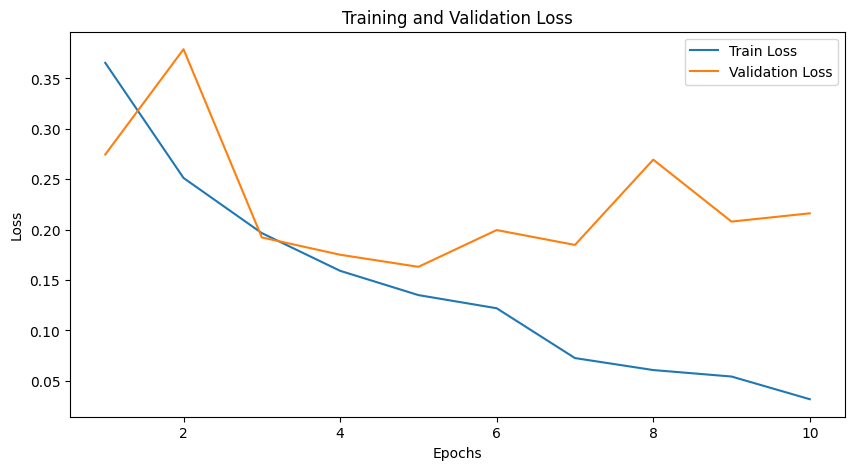

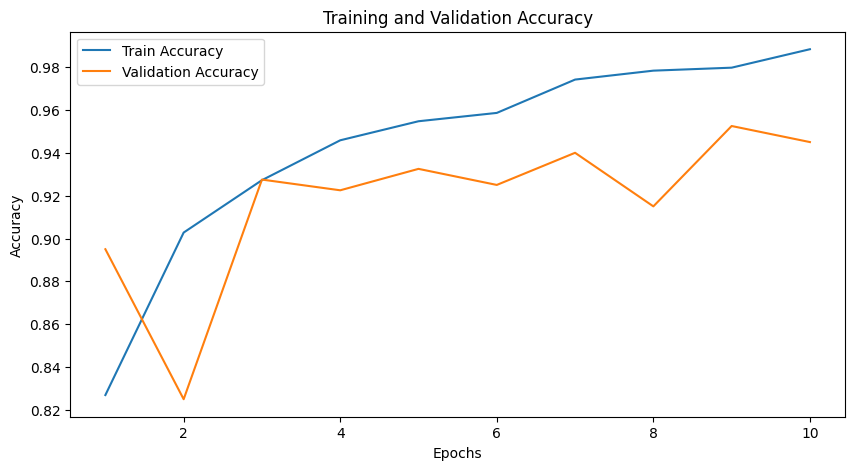

In [ ]:
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.optim import AdamW
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('test_data99.csv')  # Replace with your dataset path
print("Dataset loaded.")

# Encode the labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])  # 'legitimate' -> 0, 'phishing' -> 1
print("Labels encoded.")

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("Tokenizer loaded.")

# Define the custom Dataset class
class URLDataset(Dataset):
    def __init__(self, urls, labels, tokenizer, max_length=128):
        self.urls = urls
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        url = str(self.urls[idx])
        label = self.labels[idx]

        # Remove 'http://' or 'https://' from the URL
        if url.startswith("http://"):
            url = url[7:]  # Remove 'http://'
        elif url.startswith("https://"):
            url = url[8:]  # Remove 'https://'

        # Remove 'www.' if it exists
        if url.startswith("www."):
            url = url[4:]  # Remove 'www.'

        # Tokenize the URL
        encoding = self.tokenizer.encode_plus(
            url,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        inputs = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

        return inputs

print("Dataset class defined.")

# Split the dataset into training and validation sets
train_urls, val_urls, train_labels, val_labels = train_test_split(
    df['url'], df['label_encoded'], test_size=0.1, random_state=42
)
print("Dataset split into training and validation sets.")

# Create Dataset instances
train_dataset = URLDataset(train_urls.values, train_labels.values, tokenizer)
val_dataset = URLDataset(val_urls.values, val_labels.values, tokenizer)
print("Dataset instances created.")

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
print("DataLoader instances created.")

# Initialize the BERT configuration
config = BertConfig(
    vocab_size=30522,  # Default vocab size for BERT
    hidden_size=768,  # Hidden size of BERT layers
    num_attention_heads=12,  # Number of attention heads in BERT
    num_hidden_layers=12,  # Number of layers in BERT
    intermediate_size=3072,  # Size of the intermediate feed-forward layers
    max_position_embeddings=512,  # Maximum sequence length
    num_labels=2,  # Number of output classes (phishing, legitimate)
)

# Initialize the BERT model from scratch
model = BertForSequenceClassification(config)
print("Model initialized.")

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

# Define the optimizer
#optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(model.parameters(), lr=2e-5)


# Training parameters
epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    model.train()
    total_train_loss = 0
    total_train_correct = 0
    total_train_examples = 0

    # Using tqdm to show the progress bar for training
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}", unit="batch")):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct = torch.sum(preds == labels)
        total_train_correct += correct.item()
        total_train_examples += labels.size(0)

        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / total_train_examples

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Train loss: {avg_train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')

    # Validation
    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_examples = 0


    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", unit="batch"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct = torch.sum(preds == labels)
            total_val_correct += correct.item()
            total_val_examples += labels.size(0)

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_val_correct / total_val_examples

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}')

# Plotting training and validation loss over epochs
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting training and validation accuracy over epochs
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


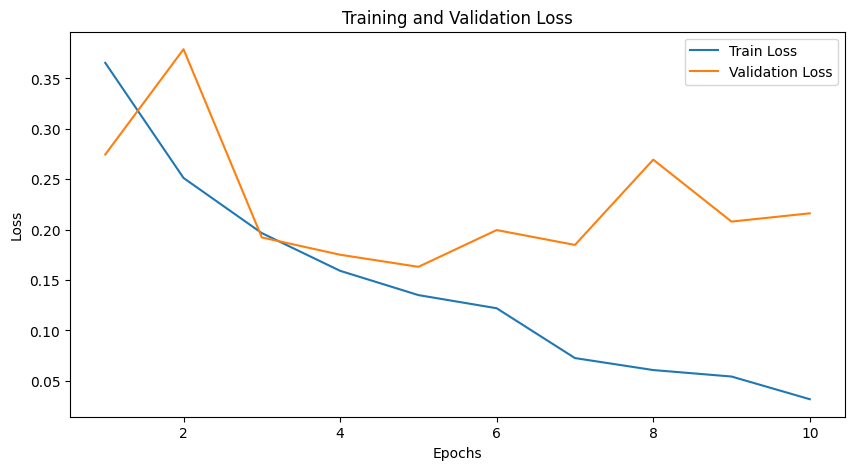

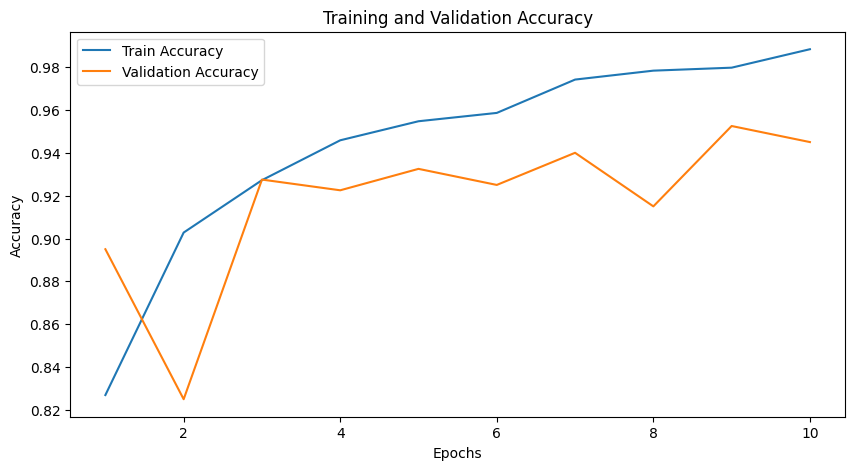

In [ ]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting training and validation accuracy over epochs
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
# Save the entire model
torch.save(model, 'bert_without_pretraining_test99_dec-2.pth')

In [ ]:
import torch

# Save the model's state_dict
torch.save(model.state_dict(), 'bert_without_pretraining_test99_dict-dec-2.pth')